In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import random
import os

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
from my_toolkit.utils.data import datasets
from my_toolkit.utils.data.datasets import DataLoader as MyDataLoader
from my_toolkit.utils.plot import Animator
from my_toolkit.models.DeepSetVarAutoEncoder import ParticleEncoder, AutoEncoder, LossFunc

In [4]:
from torchviz import make_dot
import hiddenlayer as hl

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data preparation

In [6]:
path = '/scratch2/chaoyi/DarkMachines/sm/'

In [7]:
sm_data = MyDataLoader(path)

In [8]:
next(sm_data.next())[0].shape

torch.Size([780, 80])

In [9]:
class my_dataset( Dataset ):
    def __init__( self, kine, particles ):
        self.kine = kine
        self.particles = particles

    def __len__(self):
        return len(self.particles)

    def __getitem__(self, idx):
        return self.kine[idx], self.particles[idx]

In [10]:
def prepare_data(path):
    data_obj = datasets.ReadCSVData(glob.glob(path))
    df = data_obj.data
    missing_obj = np.stack([np.zeros(len(df)), np.log10(df['MET'].values/1000), np.ones(len(df))*(-1), df['METphi'].values], axis=1)
    data = torch.concat([torch.tensor(missing_obj), torch.tensor(data_obj.kin())], axis=1)

    objects = pd.DataFrame(data_obj.objects()).fillna( np.nan ).values
    objects = np.concatenate([np.expand_dims(np.array(['M']*len(df)),axis=1), objects], axis=1)
    objects = np.vstack([np.array(['M','j','b','e-','e+','m-','m+','g',np.nan]*20, dtype='object').reshape(20,9).T, objects])
    objects = pd.DataFrame(objects)
    one_hot_encoded = pd.get_dummies(objects, dummy_na=True)[9:].values

    ready_data = my_dataset(data, torch.tensor(one_hot_encoded))

    return DataLoader( ready_data, batch_size=780, shuffle=True )

In [11]:
np1_loader = prepare_data('/scratch2/chaoyi/DarkMachines/bsm/bsm_10fb/Zp*.csv')
np2_loader = prepare_data('/scratch2/chaoyi/DarkMachines/bsm/bsm_10fb/gluino*.csv')
np3_loader = prepare_data('/scratch2/chaoyi/DarkMachines/training_files/chan1/stop2b1000_neutralino300_chan1.csv')
np4_loader = prepare_data('/scratch2/chaoyi/DarkMachines/bsm_models/simplify_models/type2seesaw_100_100.csv')

# Setup of the model, loss function, and optimizer

In [12]:
model = ParticleEncoder(13, 284, 284, 284)
autoencoder = AutoEncoder(model, 20).to(DEVICE)
loss_func = LossFunc(1,1)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=4e-4)

In [13]:
params=dict(list(autoencoder.named_parameters()))

In [14]:
train_sample = next(sm_data.next())
kine_input, class_input = train_sample[0].type(torch.float).to(DEVICE), train_sample[1].type(torch.float).to(DEVICE)
event_train_sample = torch.zeros_like(kine_input[:,:1])

for j in range(20):
    event_train_sample = torch.hstack([event_train_sample, kine_input[:,4*j:4*j+4]])
    event_train_sample = torch.hstack([event_train_sample, class_input[:,9*j:9*j+9]])
event_train_sample = event_train_sample[:,1:]

make_dot(autoencoder(event_train_sample), params=params).render("Architecture", format="png")

'Architecture.png'

In [15]:
def eval_loss(data_loader):
    test_sample = next(iter(data_loader))
    kine_input, class_input = test_sample[0].type(torch.float).to(DEVICE), test_sample[1].type(torch.float).to(DEVICE)
    event_test_sample = torch.zeros_like(kine_input[:,:1])
    for k in range(20):
        event_test_sample = torch.hstack([event_test_sample, kine_input[:,4*k:4*k+4]])
        event_test_sample = torch.hstack([event_test_sample, class_input[:,9*k:9*k+9]])
    event_test_sample = event_test_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9)        
    mean, log_var, kine_pred, class_pred = autoencoder(event_test_sample)
    test_loss = loss_func(kine_input, class_input, kine_pred, class_pred, mean, log_var)
    return test_loss

# Model training

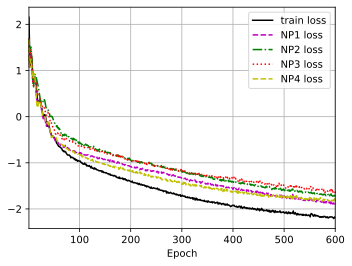

In [16]:
animator = Animator(xlabel='Epoch', xlim=[1, 600], fmts=('-k', 'm--', 'g-.', 'r:', '--y'),
                    legend=['train loss', 'NP1 loss', 'NP2 loss', 'NP3 loss', 'NP4 loss'],figsize=(5.5, 4))
train_losses = []
np1_losses = []
np2_losses = []
np3_losses = []
np4_losses = []
for i in range(600):
    train_sample = next(sm_data.next()) 
    kine_input, class_input = train_sample[0].type(torch.float).to(DEVICE), train_sample[1].type(torch.float).to(DEVICE)
    event_train_sample = torch.zeros_like(kine_input[:,:1])
    for j in range(20):
        event_train_sample = torch.hstack([event_train_sample, kine_input[:,4*j:4*j+4]])
        event_train_sample = torch.hstack([event_train_sample, class_input[:,9*j:9*j+9]])
    event_train_sample = event_train_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9) 
    mean, log_var, kine_pred, class_pred = autoencoder(event_train_sample)
    train_loss = loss_func(kine_input, class_input, kine_pred, class_pred, mean, log_var).sum()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    with torch.no_grad():
        np1_loss = eval_loss(np1_loader).sum()
        np2_loss = eval_loss(np2_loader).sum()
        np3_loss = eval_loss(np3_loader).sum()
        np4_loss = eval_loss(np4_loader).sum()
        
    animator.add(i + 1, [np.log10(train_loss.item()), np.log10(np1_loss.sum().item()), np.log10(np2_loss.item()), np.log10(np3_loss.item()), np.log10(np4_loss.item())])
    if i%10 == 0:
        train_losses.append(train_loss.item()/780)
        np1_losses.append(np1_loss.item()/780)
        np2_losses.append(np2_loss.item()/780)
        np3_losses.append(np3_loss.item()/780)
        np4_losses.append(np4_loss.item()/780)
        print('train mean loss: ', train_losses)
        print('NP1 mean loss: ',  np1_losses)
        print('NP2 mean loss: ',  np2_losses)
        print('NP3 mean loss: ',  np3_losses)
        print('NP4 mean loss: ',  np4_losses)

# Model parameters

In [17]:
torch.save(autoencoder.state_dict(), '../model_pars/DeepSetVAE_beta1_w1.pth')
# autoencoder.load_state_dict(torch.load('../model_pars/DeepSetVAE_beta1_w1.pth'))
# autoencoder.eval()

# Comparison of samples in the latent space 

In [18]:
folders = sm_data.folders

In [19]:
def eval_sample(data_loader):
    test_sample = next(iter(data_loader))
    kine_input, class_input = test_sample[0].type(torch.float).to(DEVICE), test_sample[1].type(torch.float).to(DEVICE)
    event_test_sample = torch.zeros_like(kine_input[:,:1])
    for k in range(20):
        event_test_sample = torch.hstack([event_test_sample, kine_input[:,4*k:4*k+4]])
        event_test_sample = torch.hstack([event_test_sample, class_input[:,9*k:9*k+9]])
    event_test_sample = event_test_sample[:,1:]
    kine_input, class_input = kine_input.reshape(-1,20,4), class_input.reshape(-1,20,9)        
    samples = autoencoder.encoder(event_test_sample)[2]
    return samples

In [20]:
sm_samples = {}
for i in folders:
    process = i.split('/')[-1]
    files = glob.glob(i+'/*csv')
    file_path = files[np.random.randint(len(files))]
    data_loader = prepare_data(file_path)
    with torch.no_grad():
        samples = eval_sample(data_loader)
        sm_samples[process] = samples

In [21]:
bsm_samples = {}
bsm_path = '/scratch2/chaoyi/DarkMachines/training_files/'
bsm_files = [bsm_path+'chan1/stop2b1000_neutralino300_chan1.csv', bsm_path+'chan1/monojet_Zp2000.0_DM_50.0_chan1.csv', 
             bsm_path+'chan1/sqsq1_sq1400_neut800_chan1.csv', bsm_path+'chan1/sqsq_sq1800_neut800_chan1.csv', 
             bsm_path+'chan2a/gluino_1000.0_neutralino_1.0_chan2a.csv', bsm_path+'chan2a/chaneut_cha400_neut200_chan2a.csv']
bsm_processes = ['stop2b1000', 'monojet_Zp2000', 'sqsq1_sq1400', 'sqsq_sq1800', 'gluino_1000', 'chaneut_cha400']
for file_path, process in zip(bsm_files, bsm_processes):
    data_loader = prepare_data(file_path)
    with torch.no_grad():
        samples = eval_sample(data_loader)
        bsm_samples[process] = samples

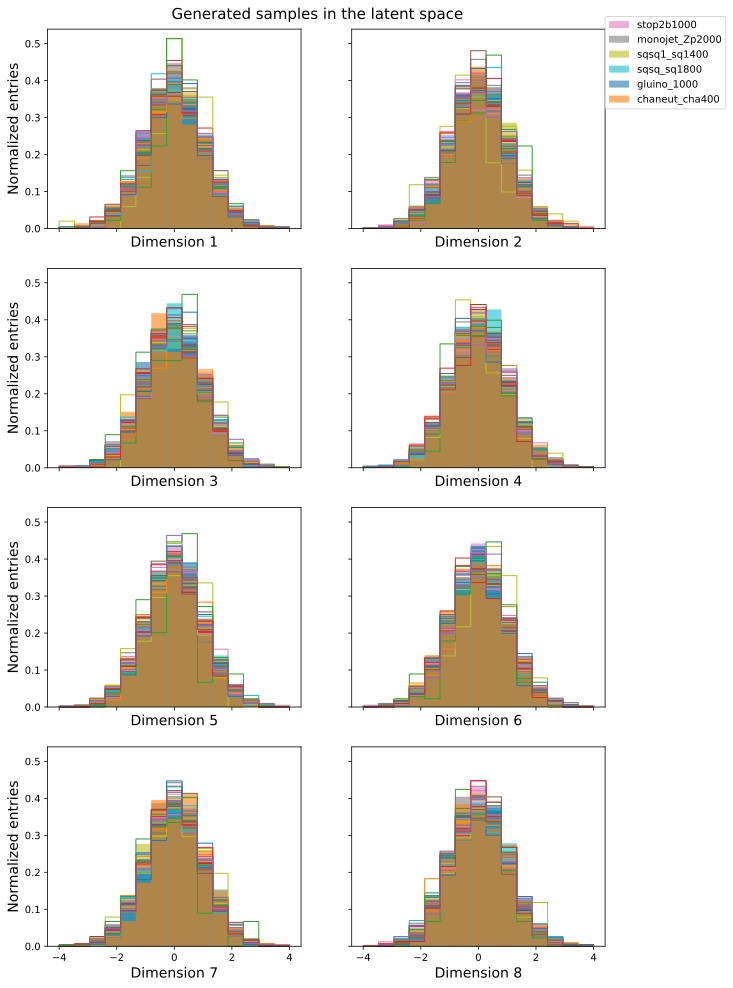

In [22]:
fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(10, 15))
fig.subplots_adjust(top=0.96)
fig.suptitle('Generated samples in the latent space', fontsize=15)
sm_accumulator = {key: torch.empty(0) for key in range(8)}
bsm_accumulator = {key: torch.empty(0) for key in range(8)}
binning = np.linspace(-4, 4, 16)

for i_dim in range(8):  
    index = int(i_dim/2), i_dim%2
    if index[1]==0:
        ax[index].set_ylabel('Normalized entries', size=14)
    ax[index].set_xlabel(f'Dimension {i_dim+1}', size=14)
    for i in sm_samples.keys():
        ax[index].hist(sm_samples[i][:,i_dim].cpu(), binning, histtype='step', density=1)
        sm_accumulator[i_dim] = torch.cat([sm_accumulator[i_dim], sm_samples[i][:,i_dim].cpu()])
    for i in bsm_samples.keys():
        ax[index].hist(bsm_samples[i][:,i_dim].cpu(), binning, label=i, density=1, alpha=0.6)
        bsm_accumulator[i_dim] = torch.cat([bsm_accumulator[i_dim], bsm_samples[i][:,i_dim].cpu()])
ax[0,1].legend(loc=(1, 0.6))
plt.show()

In [23]:
for i in range(8):
    print(f' {i+1}-th dimension:', '\n',
          'SM Mean: {:.3f} \t'.format(sm_accumulator[i].mean().numpy()),
          'Std: {:.3f}'.format(sm_accumulator[i].std().numpy()), '\n',
          'BSM Mean: {:.3f} \t'.format(bsm_accumulator[i].mean().numpy()),
          'Std: {:.3f}'.format(bsm_accumulator[i].std().numpy()), '\n',
          '----------------------------------')

 1-th dimension: 
 SM Mean: 0.001 	 Std: 1.010 
 BSM Mean: -0.004 	 Std: 0.990 
 ----------------------------------
 2-th dimension: 
 SM Mean: -0.002 	 Std: 0.999 
 BSM Mean: 0.032 	 Std: 0.988 
 ----------------------------------
 3-th dimension: 
 SM Mean: 0.006 	 Std: 1.000 
 BSM Mean: -0.014 	 Std: 1.001 
 ----------------------------------
 4-th dimension: 
 SM Mean: -0.009 	 Std: 1.003 
 BSM Mean: 0.022 	 Std: 1.012 
 ----------------------------------
 5-th dimension: 
 SM Mean: -0.003 	 Std: 0.994 
 BSM Mean: 0.014 	 Std: 1.008 
 ----------------------------------
 6-th dimension: 
 SM Mean: 0.003 	 Std: 1.000 
 BSM Mean: -0.006 	 Std: 0.987 
 ----------------------------------
 7-th dimension: 
 SM Mean: 0.005 	 Std: 0.999 
 BSM Mean: 0.000 	 Std: 1.004 
 ----------------------------------
 8-th dimension: 
 SM Mean: 0.004 	 Std: 1.004 
 BSM Mean: 0.010 	 Std: 0.977 
 ----------------------------------


# Comparison of loss

In [24]:
sm_samples = {}
for i in folders:
    process = i.split('/')[-1]
    files = glob.glob(i+'/*csv')
    file_path = files[np.random.randint(len(files))]
    data_loader = prepare_data(file_path)
    with torch.no_grad():
        loss = eval_loss(data_loader)
        sm_samples[process] = loss

In [25]:
bsm_samples = {}
for file_path, process in zip(bsm_files, bsm_processes):
    data_loader = prepare_data(file_path)
    with torch.no_grad():
        loss = eval_loss(data_loader)
        bsm_samples[process] = loss

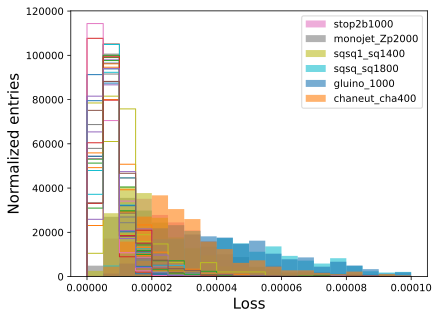

In [26]:
binning = np.linspace(0, 0.0001, 21)

for i in sm_samples.keys():
    plt.hist(sm_samples[i].cpu(), binning, histtype='step', density=1)
for i in bsm_samples.keys():
    plt.hist(bsm_samples[i].cpu(), binning, label=i, density=1, alpha=0.6)
plt.legend()
plt.xlabel('Loss', size=15)
plt.ylabel('Normalized entries', size=15)
plt.show()